# Setup

analysis of data

(0) plot best fit spectrum, incl. passbands

(1) plot main plot with dyplot, compare with input

(2) plot SFH, compare with input

(3) plot weighted histograms and percentiles

=> write flexible functions that can be adopted elsewhere!


In [23]:
# import modules

import numpy as np

from prospect.io import read_results as pr
from dynesty import plotting as dyplot
from wquantiles import quantile
from astropy.table import Table

import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'stixsans'
plt.rcParams['font.family'] = 'sans'
plt.rcParams['font.serif'] = 'STIXGeneral'
from matplotlib.ticker import MaxNLocator


In [2]:
# define paths

path_main = '/Users/sandrotacchella/ASTRO/JWST/Proposal_GO_Cycle1/spec_vs_phot/results/'

path_figure = '/Users/sandrotacchella/ASTRO/JWST/Proposal_GO_Cycle1/figures/'

path_spectra = '/Users/sandrotacchella/ASTRO/JWST/Proposal_GO_Cycle1/spec_vs_phot/data/'


In [57]:
# read in SFHs and other truths

table_sfh = Table.read(path_spectra + 'example_sfh.txt', format='ascii')
table_comp = Table.read(path_spectra + 'example_components.txt', format='ascii')

components = table_comp['components']
component = components[6]
file_name = 'mock_svp_6_1522188512_mcmc.h5'



components
----------
    bulge1
    bulge2
    bulge3
    bulge4
      disk
    clump1
    clump2
    clump3


# Define Functions

In [3]:
# define functions

def zfrac_to_masses(total_mass=None, z_fraction=None, agebins=None, **extras):
    """This transforms from independent dimensionless `z` variables to sfr
    fractions and then to bin mass fractions. The transformation is such that
    sfr fractions are drawn from a Dirichlet prior.  See Betancourt et al. 2010

    :returns masses:
        The stellar mass formed in each age bin.
    """
    # sfr fractions (e.g. Leja 2016)
    sfr_fraction = np.zeros(len(z_fraction) + 1)
    sfr_fraction[0] = 1.0 - z_fraction[0]
    for i in range(1, len(z_fraction)):
        sfr_fraction[i] = np.prod(z_fraction[:i]) * (1.0 - z_fraction[i])
    sfr_fraction[-1] = 1 - np.sum(sfr_fraction[:-1])

    # convert to mass fractions
    time_per_bin = np.diff(10**agebins, axis=-1)[:, 0]
    sfr_fraction *= np.array(time_per_bin)
    sfr_fraction /= sfr_fraction.sum()

    masses = total_mass * sfr_fraction
    return masses


# Read in Data (incl. conversion)

In [4]:
# read in results

res, obs, mod = pr.results_from(path_main + file_name, dangerous=True)
sps = pr.get_sps(res)
mod._config_dict["mass"]["depends_on"] = zfrac_to_masses


Could not check SSP library versions.


In [5]:
# mimic dynesty outputs
res['logwt'] = np.log(res['weights'])+res['logz'][-1]
res['logl'] = res['lnlikelihood']
res['samples'] = res['chain']


/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


In [6]:
# make labels
print mod.theta_labels()
theta_labels = [r'$\log\/\/\/\mathrm{M}_{\star}$', 'z_frac_1', 'z_frac_2', 'z_frac_3', 'z_frac_4', 'z_frac_5', r'$Z_{\star}$', r'$\tau$', r'$\log\/u$', r'$\sigma_{\star}$']
theta_log_q = np.array([True, False, False, False, False, False, False, False, False, False])


['total_mass', 'z_fraction_1', 'z_fraction_2', 'z_fraction_3', 'z_fraction_4', 'z_fraction_5', 'logzsol', 'dust2', 'gas_logu', 'sigma_smooth']


In [7]:
ndim = len(mod.theta_labels())

In [8]:
res['run_params']

{u'add_neb_emission': False,
 u'agelims': [0.0, 7.3, 8.0, 8.5, 9.0, 9.3, 9.5],
 u'debug': False,
 u'i_comp': 6.0,
 u'infile_phot': u'data/example_mags.txt',
 u'infile_spec': u'data/example_spectra_with_noise.txt',
 u'logify_spectrum': False,
 u'mask_elines': True,
 u'nested_bound': u'multi',
 u'nested_dlogz_init': 0.01,
 u'nested_nlive_batch': 100,
 u'nested_nlive_init': 100,
 u'nested_sample': u'rslice',
 u'nested_slices': 6,
 u'nested_stop_kwargs': {u'n_mc': 50, u'post_thresh': 0.05},
 u'nested_weight_kwargs': {u'pfrac': 1.0},
 u'normalize_spectrum': False,
 u'outfile': u'/n/home03/stacchella/proposals/spec_vs_phot//results/mock_svp_6',
 u'param_file': u'/n/home03/stacchella/proposals/spec_vs_phot//nonparametric_spec_fitting.py',
 u'phot': False,
 u'polyorder': 0,
 u'rescale_spectrum': False,
 u'spec': True,
 u'sps_libraries': [u'mist', u'miles'],
 u'sys.argv': [u'/n/home03/stacchella/programs//prospector/scripts/prospector_dynesty.py',
  u'--param_file=/n/home03/stacchella/proposals

In [9]:
res

{u'chain': array([[ 7.34075622e+11,  8.63393953e-01,  6.02317372e-01, ...,
          9.17478882e-02, -1.90711168e+00,  1.59113577e+02],
        [ 5.04405786e+11,  5.13630547e-01,  6.53746460e-01, ...,
          7.15006463e-01, -2.70536528e+00,  6.38892342e+01],
        [ 7.94980315e+11,  8.16914976e-01,  3.47858229e-01, ...,
          1.15656191e+00, -1.61123442e+00,  5.66196531e+01],
        ...,
        [ 2.12157802e+10,  7.01760516e-01,  2.40716836e-01, ...,
          1.51573163e-02, -1.73213481e+00,  1.43478424e+02],
        [ 2.11110222e+10,  7.02966611e-01,  2.38367793e-01, ...,
          1.48337679e-02, -1.73499820e+00,  1.43467404e+02],
        [ 2.11058832e+10,  7.03397650e-01,  2.37785477e-01, ...,
          1.43186627e-02, -1.73642318e+00,  1.43407842e+02]]),
 u'efficiency': array([3.73627775]),
 u'information': array([ 5.30604494,  5.31847744,  5.32814665, ..., 20.91004191,
        20.91186728, 20.91392973]),
 u'lnlikelihood': array([-7645887.95872252, -3182161.29083982, -1

In [10]:
# find best fit

ind = res['lnprobability'].argmax()
print ind
theta_max = res['chain'][ind]
print theta_max

spec, phot, x = mod.mean_model(theta_max, obs=obs, sps=sps)


5271
[ 2.11058832e+10  7.03397650e-01  2.37785477e-01  4.33565345e-01
  9.93481450e-01  4.53572754e-01 -5.23018262e-01  1.43186627e-02
 -1.73642318e+00  1.43407842e+02]


# Plot Spectrum

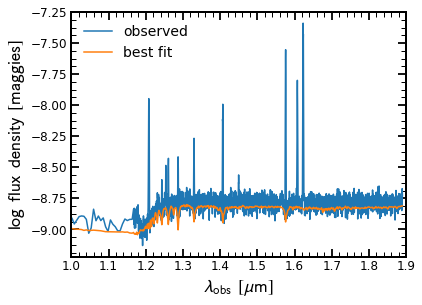

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(6.0, 4.5))

axes.plot(obs['wavelength']/10**4, np.log10(obs['spectrum']), '-', color='C0', label='observed')
axes.plot(obs['wavelength']/10**4, np.log10(spec), '-', color='C1', label='best fit')

axes.set_xlim([1.0, 1.9])
#axes.set_ylim([26.7, 22.8])

axes.set_xlabel(r'$\lambda_{\rm obs}\/\/\/[\mu\mathrm{m}]$', fontsize=18)
axes.set_ylabel(r'$\log\/\/\/\mathrm{flux}\/\/\/\mathrm{density}\/\/\/[\mathrm{maggies}]$', fontsize=18)
axes.legend(frameon=False, fontsize=14)

# plt.savefig(path_figure + 'investigate_resolution_spec.pdf', format='pdf', bbox_inches='tight')
plt.show()

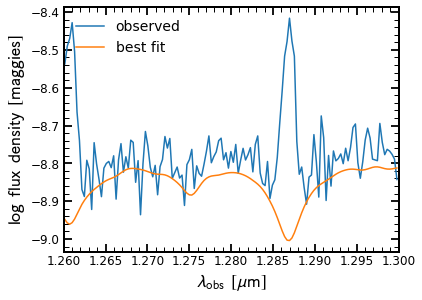

In [12]:
idx = (obs['wavelength'] > 12600) & (obs['wavelength'] < 13000)

fig, axes = plt.subplots(1, 1, figsize=(6.0, 4.5))

axes.plot(obs['wavelength'][idx]/10**4, np.log10(obs['spectrum'][idx]), '-', color='C0', label='observed')
axes.plot(obs['wavelength'][idx]/10**4, np.log10(spec[idx]), '-', color='C1', label='best fit')

axes.set_xlim([1.26, 1.3])
#axes.set_ylim([26.7, 24.0])

axes.set_xlabel(r'$\lambda_{\rm obs}\/\/\/[\mu\mathrm{m}]$', fontsize=18)
axes.set_ylabel(r'$\log\/\/\/\mathrm{flux}\/\/\/\mathrm{density}\/\/\/[\mathrm{maggies}]$', fontsize=18)
axes.legend(frameon=False, fontsize=14)

# plt.savefig(path_figure + 'investigate_resolution_spec.pdf', format='pdf', bbox_inches='tight')
plt.show()


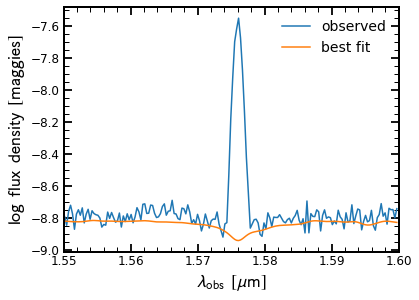

In [13]:
idx = (obs['wavelength'] > 15500) & (obs['wavelength'] < 16000)

fig, axes = plt.subplots(1, 1, figsize=(6.0, 4.5))

axes.plot(obs['wavelength'][idx]/10**4, np.log10(obs['spectrum'][idx]), '-', color='C0', label='observed')
axes.plot(obs['wavelength'][idx]/10**4, np.log10(spec[idx]), '-', color='C1', label='best fit')

axes.set_xlim([1.55, 1.6])
#axes.set_ylim([24.2, 23.2])

axes.set_xlabel(r'$\lambda_{\rm obs}\/\/\/[\mu\mathrm{m}]$', fontsize=18)
axes.set_ylabel(r'$\log\/\/\/\mathrm{flux}\/\/\/\mathrm{density}\/\/\/[\mathrm{maggies}]$', fontsize=18)
axes.legend(frameon=False, fontsize=14)

# plt.savefig(path_figure + 'investigate_resolution_spec.pdf', format='pdf', bbox_inches='tight')
plt.show()


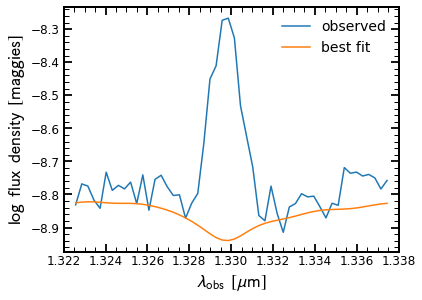

In [14]:
idx = (obs['wavelength'] > 13225) & (obs['wavelength'] < 13375)

fig, axes = plt.subplots(1, 1, figsize=(6.0, 4.5))

axes.plot(obs['wavelength'][idx]/10**4, np.log10(obs['spectrum'][idx]), '-', color='C0', label='observed')
axes.plot(obs['wavelength'][idx]/10**4, np.log10(spec[idx]), '-', color='C1', label='best fit')

axes.set_xlim([1.322, 1.338])
#axes.set_ylim([24.8, 23.8])

axes.set_xlabel(r'$\lambda_{\rm obs}\/\/\/[\mu\mathrm{m}]$', fontsize=18)
axes.set_ylabel(r'$\log\/\/\/\mathrm{flux}\/\/\/\mathrm{density}\/\/\/[\mathrm{maggies}]$', fontsize=18)
axes.legend(frameon=False, fontsize=14)

# plt.savefig(path_figure + 'investigate_resolution_spec.pdf', format='pdf', bbox_inches='tight')
plt.show()


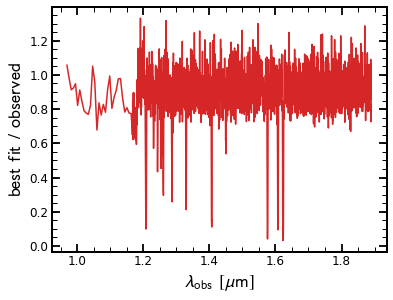

In [15]:
fig, axes = plt.subplots(1, 1, figsize=(6.0, 4.5))

axes.plot(obs['wavelength']/10**4, spec/obs['spectrum'], color='C3')

#axes.set_xlim([13225, 13375])
#axes.set_ylim([-1.2, 2.2])

axes.set_xlabel(r'$\lambda_{\rm obs}\/\/\/[\mu\mathrm{m}]$', fontsize=18)
axes.set_ylabel(r'$\mathrm{best}\/\/\/\mathrm{fit}\/\/\//\/\/\/\mathrm{observed}$', fontsize=18)

# plt.savefig(path_figure + 'investigate_resolution_spec.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Plot Trace and Histogram

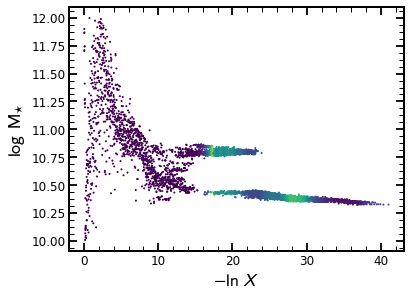

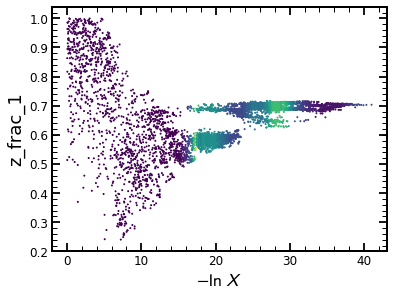

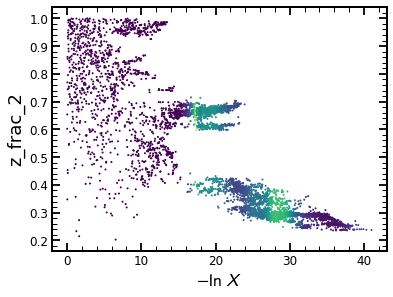

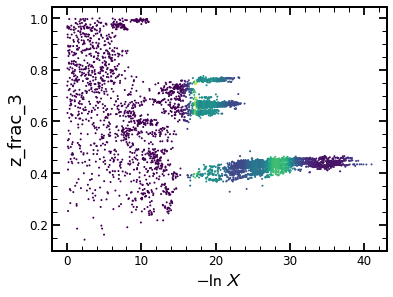

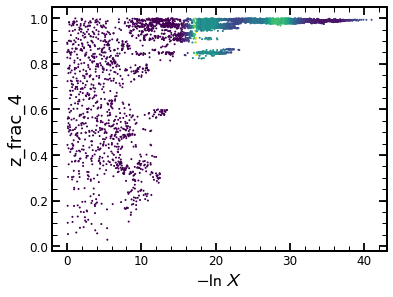

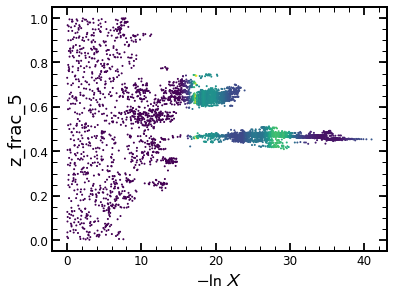

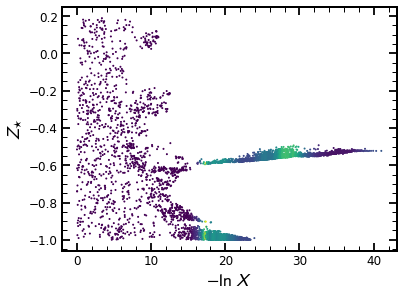

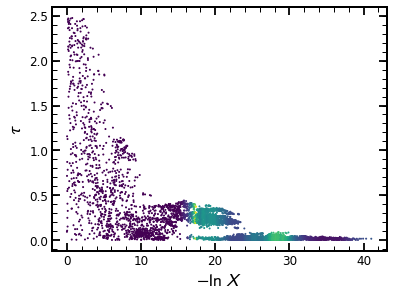

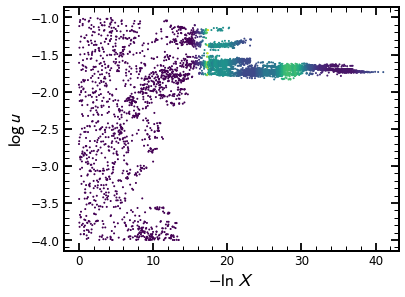

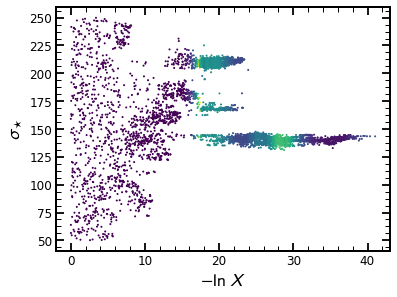

In [16]:
# plot trace

for i_theta in range(len(theta_labels)):
    fig, axes = plt.subplots(1, 1, figsize=(6.0, 4.5))
    if theta_log_q[i_theta]:
        axes.scatter(-res['logvol'], np.log10(res['chain'][:, i_theta]), c=res['weights'], s=1)
    else:
        axes.scatter(-res['logvol'], res['chain'][:, i_theta], c=res['weights'], s=1)
    axes.set_xlabel(r'$-\ln\/\/X$', fontsize=18)
    axes.set_ylabel(theta_labels[i_theta], fontsize=18)
    plt.show()



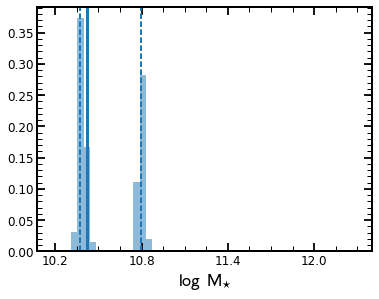

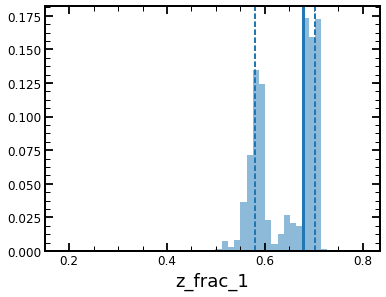

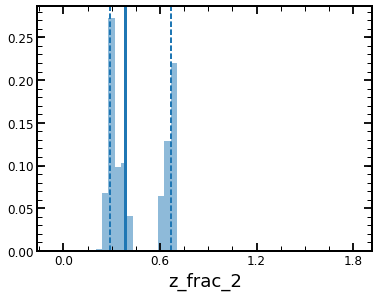

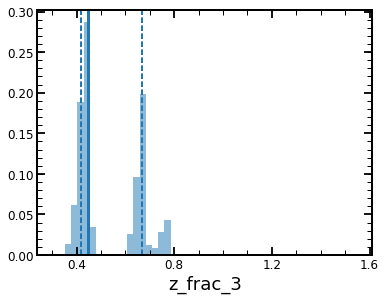

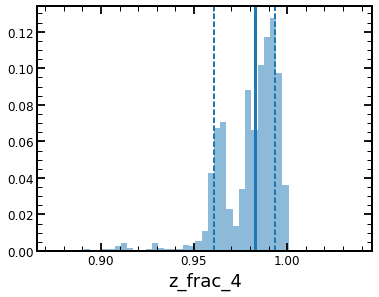

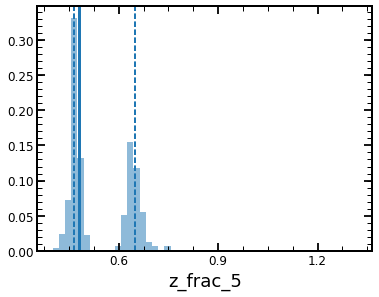

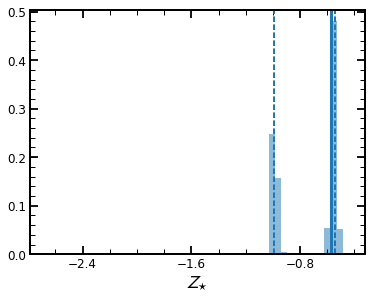

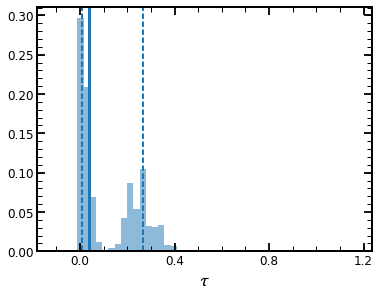

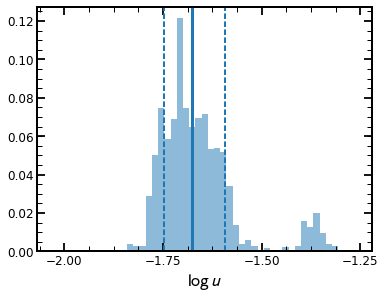

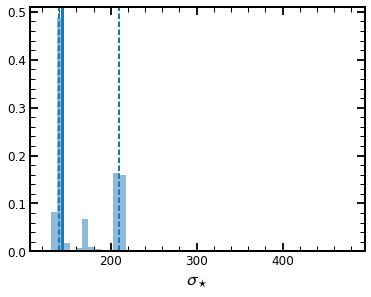

In [17]:
# plot histogram

max_n_ticks = 4

for i_theta in range(len(theta_labels)):
    # compute percentiles
    if theta_log_q[i_theta]:
        Q16 = quantile(np.log10(res['chain'][:, i_theta]), res['weights'], 0.16)
        Q50 = quantile(np.log10(res['chain'][:, i_theta]), res['weights'], 0.50)
        Q84 = quantile(np.log10(res['chain'][:, i_theta]), res['weights'], 0.84)
    else:
        Q16 = quantile(res['chain'][:, i_theta], res['weights'], 0.16)
        Q50 = quantile(res['chain'][:, i_theta], res['weights'], 0.50)
        Q84 = quantile(res['chain'][:, i_theta], res['weights'], 0.84)
    # make bins
    bins = np.linspace(Q50-5*(Q50-Q16), Q50+5*(Q84-Q50))
    # plot figure
    fig, axes = plt.subplots(1, 1, figsize=(6.0, 4.5))
    if theta_log_q[i_theta]:
        axes.hist(np.log10(res['chain'][:, i_theta]), weights=res['weights'], bins=bins, color='C0', alpha=0.5)
    else:
        axes.hist(res['chain'][:, i_theta], weights=res['weights'], bins=bins, color='C0', alpha=0.5)
    axes.axvline(x=Q16, ls='--', lw=2)
    axes.axvline(x=Q50, ls='-', lw=3)
    axes.axvline(x=Q84, ls='--', lw=2)
    axes.set_xlabel(theta_labels[i_theta], fontsize=18)
    axes.xaxis.set_major_locator(MaxNLocator(max_n_ticks, prune="lower"))
    plt.show()


# Corner Figure

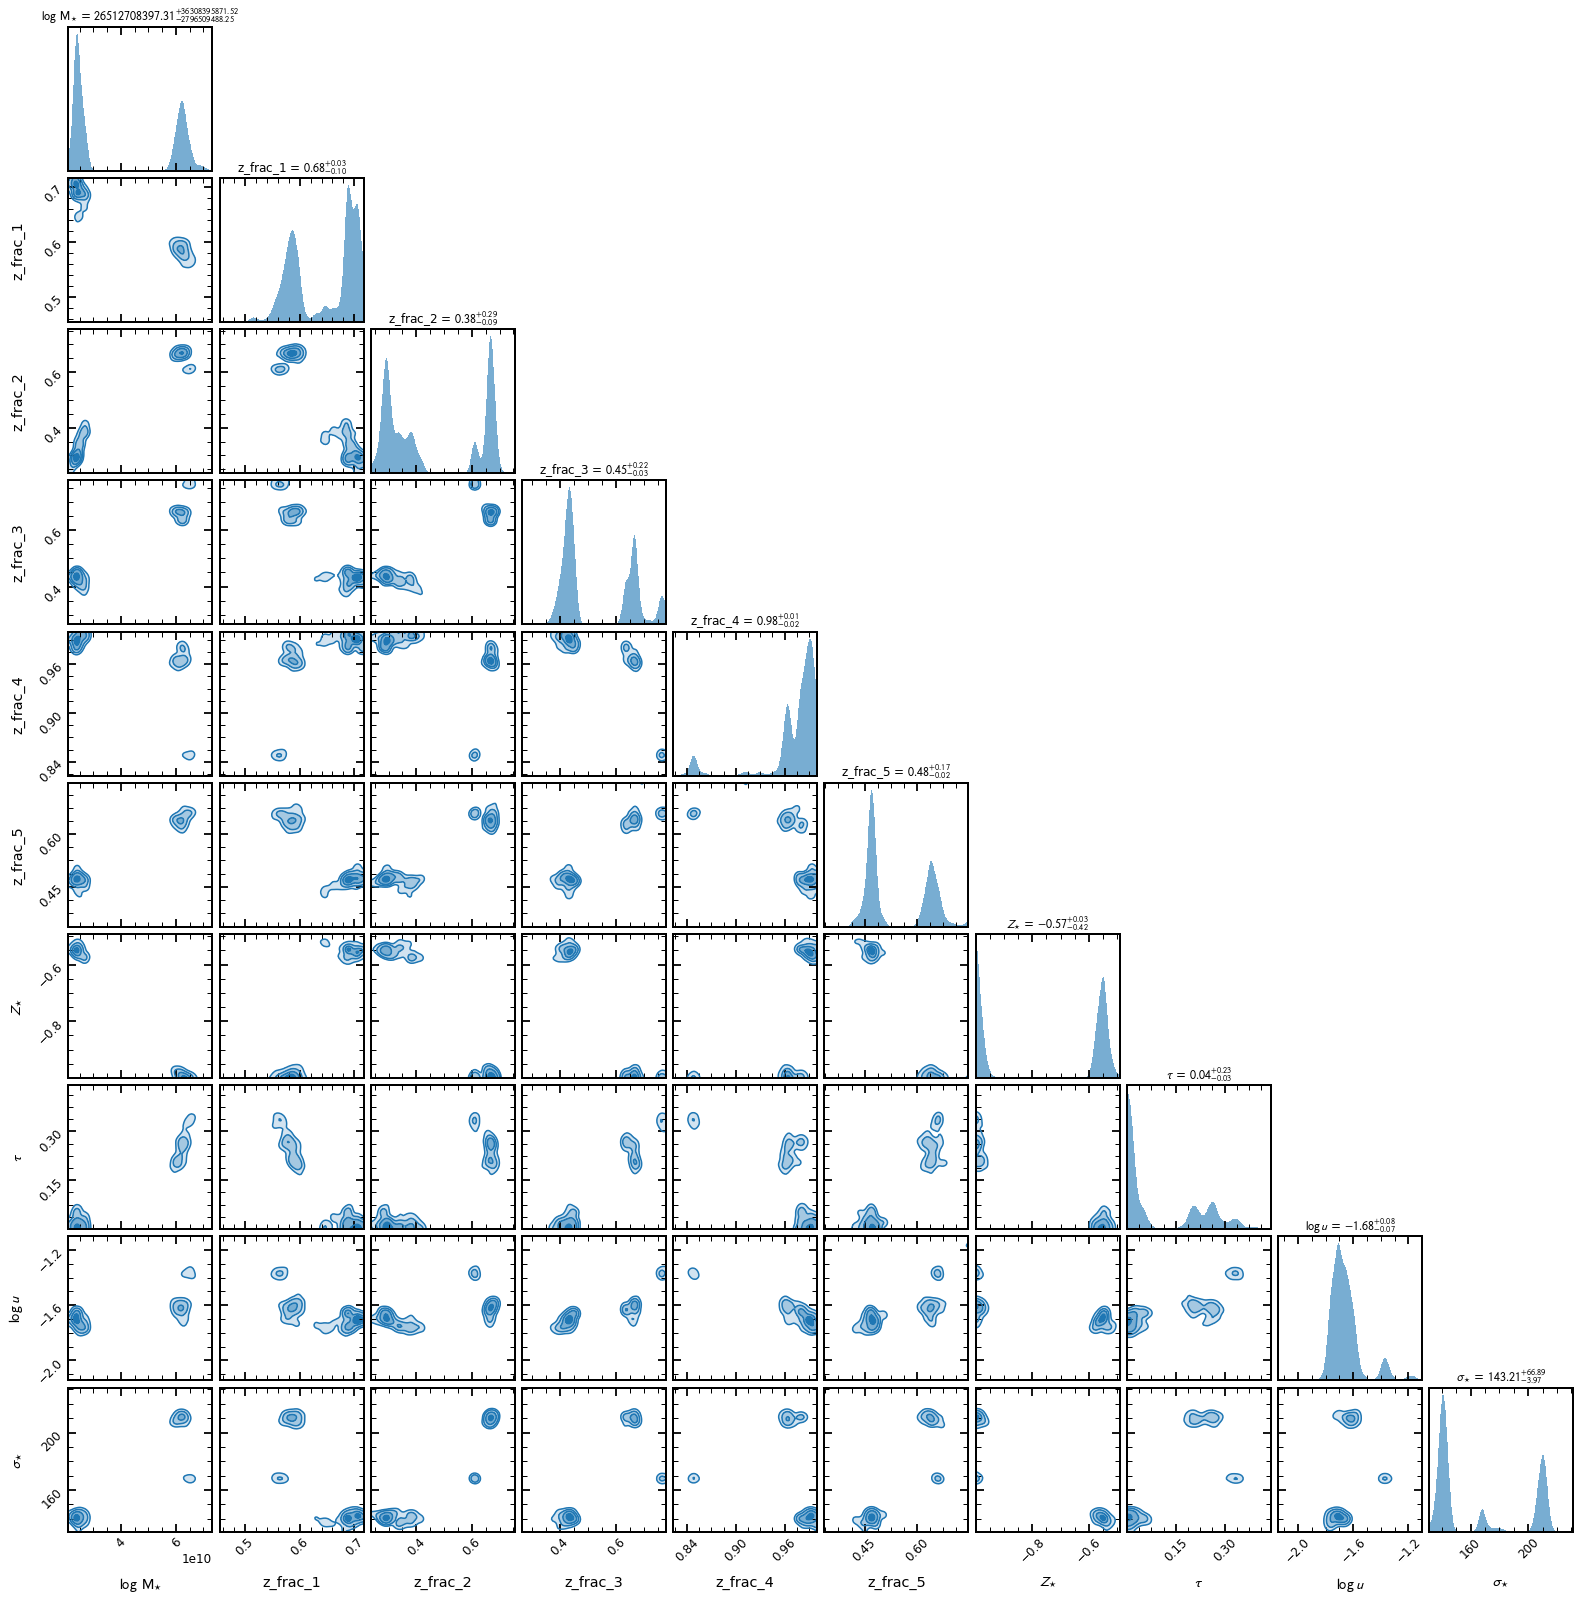

In [18]:
fig, ax = dyplot.cornerplot(res, color='C0', truths=np.zeros(ndim), labels=theta_labels,
                           truth_color='C3', show_titles=True,
                           max_n_ticks=3, quantiles=None)
plt.show()

# Star-Formation History

In [19]:

def get_SFH(res, mod):
    # get mass formed
    for i_chain in range(res['chain'].shape[0]):
        if (i_chain < 1):
            M_formed = zfrac_to_masses(total_mass=res['chain'][i_chain, 0], z_fraction=res['chain'][i_chain, 1:6], agebins=mod.params['agebins'])
        else:
            M_formed = np.vstack([M_formed, zfrac_to_masses(total_mass=res['chain'][i_chain,0], z_fraction=res['chain'][i_chain,1:6], agebins=mod.params['agebins'])])
    # convert mass formed to SFR
    SFR_mat = M_formed/np.squeeze(np.diff(10**mod.params['agebins'], axis=1))
    # compute weighted percentiles
    SFR_16 = []
    SFR_50 = []
    SFR_84 = []
    for i_age_bin in range(SFR_mat.shape[1]):
        SFR_16 = np.append(SFR_16, quantile(SFR_mat[:, i_age_bin], res['weights'], 0.16))
        SFR_50 = np.append(SFR_50, quantile(SFR_mat[:, i_age_bin], res['weights'], 0.50))
        SFR_84 = np.append(SFR_84, quantile(SFR_mat[:, i_age_bin], res['weights'], 0.84))
    return(10**mod.params['agebins'].flatten()/10**9, np.repeat(SFR_16, 2), np.repeat(SFR_50, 2), np.repeat(SFR_84, 2))



In [20]:
age_bins, SFR_16, SFR_50, SFR_84 = get_SFH(res, mod)


In [53]:
SFR_input = []

for i_age in range(mod.params['agebins'].shape[0]):
    idx = (table_sfh['time'] <= 3.0-10**(mod.params['agebins'][i_age][0]-9.0)) & (table_sfh['time'] >= 3.0-10**(mod.params['agebins'][i_age][1]-9.0))
    M_formed = np.trapz(table_sfh['SFR_' + component][idx], 10**9*table_sfh['time'][idx])
    SFR_input = np.append(SFR_input, M_formed/np.diff(10**mod.params['agebins'], axis=1)[i_age][0])


In [55]:
SFR_input = np.repeat(SFR_input, 2)

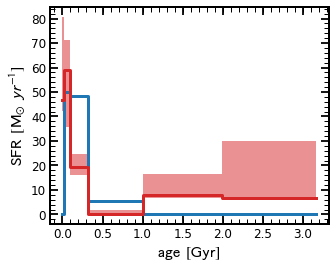

In [56]:
f, axes = plt.subplots(1, 1, figsize=(5.0, 4.0))

axes.plot(age_bins, SFR_input, lw=3, color='C0', alpha=1.0, zorder=5)
axes.plot(age_bins, SFR_50, lw=3, color='C3', alpha=1.0, zorder=5)
axes.fill_between(age_bins, SFR_16, SFR_84, lw=0, color='C3', alpha=0.5, zorder=2)



# plot typical uncertainty of fit
#axes.errorbar(-12.0, 18.0, xerr=[[np.median(err_h_up)], [np.median(err_h_down)]], fmt='o', color='C3', alpha=0.5)
#axes.errorbar(-12.0, 15.0, xerr=[[np.median(err_l_up)], [np.median(err_l_down)]], fmt='o', color='C0', alpha=0.5)

#axes.set_xlim([-31, 30])
#axes.set_ylim([0.0, 250.0])
axes.set_xlabel(r'$\mathrm{age}\/\/\/[\mathrm{Gyr}]$', fontsize=16)
axes.set_ylabel(r'$\mathrm{SFR}\/\/\/[\mathrm{M_{\odot}}\/\/\/yr^{-1}]$', fontsize=16)
plt.legend(frameon=False, fontsize=12)
#plt.savefig(path_figure + 'investigate_resolution_EW_dist.pdf', format='pdf', bbox_inches='tight')
plt.show()

